In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from IPython.display import display, Image
import matplotlib.pyplot as plt

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [77]:
batch_size = 16
depth = 32

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size*image_size*num_channels, num_labels], stddev=0.1))
  bias = tf.Variable(tf.zeros([num_labels]))
  Aweights = tf.Variable(tf.truncated_normal([image_size*image_size*num_channels, num_labels], stddev=0.01))
  Abias = tf.Variable(tf.zeros([num_labels]))
  Bweights = tf.Variable(tf.truncated_normal([image_size*image_size*num_channels, num_labels], stddev=0.01))
  Bbias = tf.Variable(tf.zeros([num_labels]))
  #a = tf.Variable(tf.zeros([batch_size]))
  #b = tf.Variable(tf.zeros([batch_size]))
  
  # Model.
  def model(data, adjust=True):
    if adjust:
      shape = data.get_shape().as_list()
      layer = tf.reshape(data, [shape[0], shape[1] * shape[2] * shape[3]])
      a = tf.matmul(layer,Aweights) + Abias
      b = tf.matmul(layer,Bweights) + Bbias
    else:
      a = 0.
      b = 0.
    Xtransform = np.array([[(1. if i==(j+a)%image_size else 0) for i in range(image_size)] for j in range(image_size)])
    XT = tf.constant(Xtransform,dtype=tf.float32)
    transform = tf.transpose(tf.tensordot(data, XT, [[2],[0]]),[0,1,3,2])
    Ytransform = np.array([[(1 if i==(j)%image_size else 0) for i in range(image_size)] for j in range(image_size)])
    YT = tf.constant(Ytransform,dtype=tf.float32)
    transform = tf.transpose(tf.tensordot(transform, YT, [[1],[1]]),[0,3,1,2])
    shape = data.get_shape().as_list()
    layer = tf.reshape(data, [shape[0], shape[1] * shape[2] * shape[3]])
    return {"logits": tf.matmul(layer,weights) + bias, "a": a, "b": b}
  
  # Training computation.
  output = model(tf_train_dataset,False)
  logits = output["logits"]
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  a = output["a"]
  constraint_loss = tf.reduce_mean(tf.maximum( tf.multiply(-(a-image_size/2*tf.ones([batch_size])),(a+image_size/2*tf.ones([batch_size]))) ,0))
  b = output["b"]
  constraint_loss += tf.reduce_mean(tf.maximum( tf.multiply(-(b-image_size/2*tf.ones([batch_size])),(b+image_size/2*tf.ones([batch_size]))) ,0))
  improved_logits = model(tf_train_dataset,True)
  improved_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=improved_logits)) + constraint_loss
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  improved_optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(improved_loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset,True))
  test_prediction = tf.nn.softmax(model(tf_test_dataset,True))

TypeError: Expected binary or unicode string, got {'a': <tf.Tensor 'add_4:0' shape=(16, 10) dtype=float32>, 'logits': <tf.Tensor 'add_790:0' shape=(16, 10) dtype=float32>, 'b': <tf.Tensor 'add_5:0' shape=(16, 10) dtype=float32>}

In [42]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(100):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print("beginning future of mankind")
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.532823
Minibatch accuracy: 6.2%
Validation accuracy: 13.3%
Minibatch loss at step 50: 2.154936
Minibatch accuracy: 25.0%
Validation accuracy: 47.8%
Minibatch loss at step 100: 1.445723
Minibatch accuracy: 56.2%
Validation accuracy: 63.2%
Minibatch loss at step 150: 0.928321
Minibatch accuracy: 75.0%
Validation accuracy: 69.6%
Minibatch loss at step 200: 0.852564
Minibatch accuracy: 68.8%
Validation accuracy: 73.0%
Minibatch loss at step 250: 1.284447
Minibatch accuracy: 75.0%
Validation accuracy: 74.9%
Minibatch loss at step 300: 0.667410
Minibatch accuracy: 87.5%
Validation accuracy: 76.3%
Minibatch loss at step 350: 0.765545
Minibatch accuracy: 87.5%
Validation accuracy: 77.3%
Minibatch loss at step 400: 0.906759
Minibatch accuracy: 75.0%
Validation accuracy: 77.7%
Minibatch loss at step 450: 1.227785
Minibatch accuracy: 81.2%
Validation accuracy: 78.1%
Minibatch loss at step 500: 0.674903
Minibatch accuracy: 87.5%
Validation accuracy: 78.3%
Mi

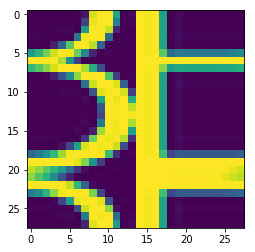

In [39]:
offset = (1 * batch_size) % (train_labels.shape[0] - batch_size)
batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
batch_labels = train_labels[offset:(offset + batch_size), :]
XT = np.array([[(1. if i==(j+14)%image_size else 0) for i in range(image_size)] for j in range(image_size)])
transform = np.transpose(np.tensordot(batch_data, XT, [[2],[0]]),[0,1,3,2])
YT = np.array([[(1 if i==(j+7)%image_size else 0) for i in range(image_size)] for j in range(image_size)])
transform = np.transpose(np.tensordot(transform, YT, [[1],[1]]),[0,3,1,2])
plt.imshow(transform[[0]][0,:,:,0])
plt.show()

In [78]:
[[1,2],[2,3],[3,4],[4,5]]+[1,2]

[[1, 2], [2, 3], [3, 4], [4, 5], 1, 2]